In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
g = np.array([[1,2,3],[1,2,3]])
np.repeat(g[:, np.newaxis], 3, axis=1)

array([[[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]],

       [[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]]])

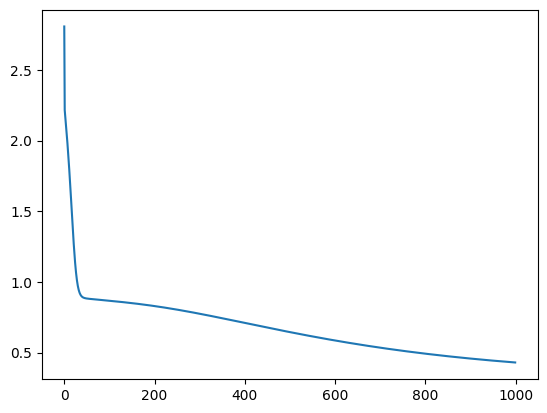

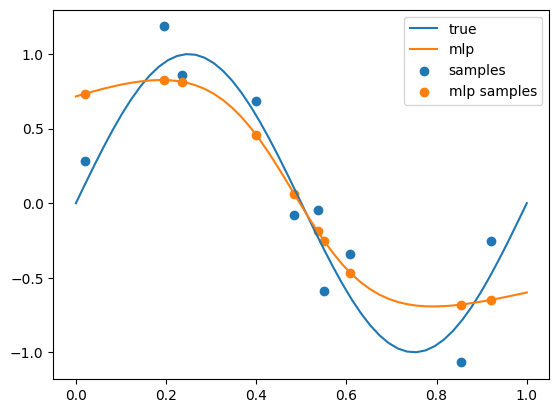

In [28]:
class MLP():
    
    def __init__(self, x, yt):
        self.x = x
        self.yt = yt
        self.w1, self.w2, self.b1, self.b2 = self.__initWeights()
    
    def __initWeights(self):
        
        neuronsPerLayer = 3
        
        w1 = np.zeros(neuronsPerLayer**2).reshape([neuronsPerLayer,neuronsPerLayer])
        w1[0,:] = np.random.uniform(-0.5,0.5,neuronsPerLayer)

        w2 = np.zeros(neuronsPerLayer**2).reshape([neuronsPerLayer,neuronsPerLayer])
        w2[:,0] = np.random.uniform(-0.5,0.5,neuronsPerLayer)

        b1 = np.zeros(neuronsPerLayer)
        b1[:] = np.random.uniform(-0.5,0.5,neuronsPerLayer) 

        b2 = np.zeros(neuronsPerLayer)
        b2[0] = np.random.uniform(-0.5,0.5,1)

        return w1, w2, b1, b2
    
    def __activationHidden(self, x):
        return np.tanh(x)

    def __activationHiddenPrime(self, x):
        return (1- np.tanh(x)**2)

    def __inputLayer(self, x):
        h0 = x 
        f0 = h0
        return h0, f0

    def __hiddenLayer(self, f0, w1, b1):
        h1 = f0 @ w1 + b1
        f1 = self.__activationHidden(h1)
        return h1, f1

    def __outputLayer(self, f1, w2, b2):
        h2 = f1 @ w2 + b2
        f2 = h2
        return h2, f2

    def __forward(self, x,w1,w2,b1,b2):
        h0,f0 = self.__inputLayer(x)
        h1,f1 = self.__hiddenLayer(f0,w1,b1)
        h2,f2 = self.__outputLayer(f1,w2,b2)
        return h0,h1,h2,f0,f1,f2

    def __outputError(self, y, yt):
        return 1/2 * (y - yt)**2

    def __outputErrorPrime(self, y, yt):
        return y - yt
    
    def getError(self):
        return self.__outputError(self.y, self.yt).sum()
    
    def __localErrors(self, h1, w2):
        delta2 = np.zeros([len(h1), 3])
        delta2[:, 0] = 1

        delta1 = self.__activationHiddenPrime(h1) * delta2 @ w2.T 
        return delta1, delta2
    
    def __gradients(self, y, yt, delta1, delta2, f0, f1, verbose=False):
        gradient_y = self.__outputErrorPrime(y,yt)

        dyb1 = delta1
        dyb2 = delta2

        dyw1 = np.expand_dims(f0, axis=2) @ np.expand_dims(delta1, axis=1)
        dyw2 = np.expand_dims(f1, axis=2) @ np.expand_dims(delta2, axis=1)
        
        gradient_b1 = dyb1 * gradient_y 
        gradient_b2 = dyb2 * gradient_y
        
        shape1 = dyw1.shape[1]
        shape2 = dyw2.shape[1]
        
        gradient_w1 = dyw1 * np.repeat(gradient_y[:, np.newaxis], 3, axis=1)
        gradient_w2 = dyw2 * np.repeat(gradient_y[:, np.newaxis], 3, axis=1)
#         print(gradient_w1)
#         gradient_w1 = dyw1 * np.repeat(gradient_y[:,0], shape1**2).reshape(-1,shape1,shape1)
#         gradient_w2 = dyw2 * np.repeat(gradient_y[:,0], shape2**2).reshape(-1,shape2,shape2)

        gradient_b1 = gradient_b1.mean(0)
        gradient_b2 = gradient_b2.mean(0)
        gradient_w1 = gradient_w1.mean(0)
        gradient_w2 = gradient_w2.mean(0)
       
        return gradient_w1, gradient_w2, gradient_b1, gradient_b2

    def __update_weights(self, w1,w2,b1,b2,gradient_w1,gradient_w2,gradient_b1,gradient_b2,learning_rate=0.05):
        w1 -= learning_rate * gradient_w1
        w2 -= learning_rate * gradient_w2
        b1 -= learning_rate * gradient_b1
        b2 -= learning_rate * gradient_b2

        return w1,w2,b1,b2
    
    def iterate(self, lr=0.7):
        h0,h1,h2,f0,f1,self.y = self.__forward(self.x, self.w1, self.w2, self.b1, self.b2)

        eprime = self.__outputErrorPrime(self.y, self.yt)
        
        delta1, delta2 = self.__localErrors(h1, self.w2)
        gradient_w1, gradient_w2, gradient_b1, gradient_b2 = self.__gradients(self.y, self.yt, delta1, delta2, f0, f1)
    
        self.w1, self.w2, self.b1, self.b2 = self.__update_weights(self.w1, self.w2, self.b1, self.b2, gradient_w1, gradient_w2, gradient_b1, gradient_b2, lr)
        
    def getOutput(self, x):
        _,_,_,_,_,y = self.__forward(x, self.w1, self.w2, self.b1, self.b2)
        return y

inputDataCreator = InputDataCreator()
x, yt = inputDataCreator.getData()

mlp = MLP(x, yt)

errors = []
for i in range(1000):
    mlp.iterate(0.7)
    errors.append(mlp.getError())

plt.plot(np.arange(len(errors)), errors)
plt.show()

plotter = Plotter()
plotter.plotresult(mlp, x, yt)

In [4]:
class InputDataCreator():
    def __getX(self):
        data = np.genfromtxt('RegressionData.txt', delimiter=' ')
        x = data[:,0]
        x = x[:, np.newaxis]
        x = np.block([x, np.zeros(len(x)*2).reshape(-1,2)]) 
        return x 

    def __getY(self):
        data = np.genfromtxt('RegressionData.txt', delimiter=' ')
        y = data[:,1]
        y = y[:, np.newaxis]
        y = np.block([y, np.zeros(len(y)*2).reshape(-1,2)])
        return y
    
    def getData(self):
        return self.__getX(), self.__getY()
    
    def getDataTrue(self):
        xspace = np.linspace(0, 1, 50, endpoint=True)
        xspace = xspace[:, np.newaxis]
        xspace = np.block([xspace, np.zeros(len(xspace)*2).reshape(-1,2)]) 
        
        yspace = np.sin(2 * np.pi * xspace)     
        
        return xspace, yspace

inputDataCreator = InputDataCreator() 
inputDataCreator.getData()

(array([[0.5503, 0.    , 0.    ],
        [0.9206, 0.    , 0.    ],
        [0.5359, 0.    , 0.    ],
        [0.6081, 0.    , 0.    ],
        [0.0202, 0.    , 0.    ],
        [0.8545, 0.    , 0.    ],
        [0.2357, 0.    , 0.    ],
        [0.4847, 0.    , 0.    ],
        [0.3996, 0.    , 0.    ],
        [0.1957, 0.    , 0.    ]]),
 array([[-0.5894,  0.    ,  0.    ],
        [-0.2507,  0.    ,  0.    ],
        [-0.0468,  0.    ,  0.    ],
        [-0.3402,  0.    ,  0.    ],
        [ 0.2857,  0.    ,  0.    ],
        [-1.0683,  0.    ,  0.    ],
        [ 0.8605,  0.    ,  0.    ],
        [-0.0801,  0.    ,  0.    ],
        [ 0.6837,  0.    ,  0.    ],
        [ 1.185 ,  0.    ,  0.    ]]))

In [5]:
class Plotter():
    
    def plotresult(self, mlp, x, yt):
        xspace = np.linspace(0, 1, 50, endpoint=True)
        yspace = np.sin(2 * np.pi * xspace)

        ymlp = mlp.getOutput(x)

        xmlpspace = xspace[:, np.newaxis]
        xmlpspace = np.block([xmlpspace, np.zeros(len(xmlpspace)*2).reshape(-1,2)]) 
        ymlpspace = mlp.getOutput(xmlpspace)

        plt.plot(xspace, yspace, label='true')
        plt.plot(xspace, ymlpspace[:,0], label='mlp')

        plt.scatter(x[:,0],yt[:,0], marker='o', label='samples')
        plt.scatter(x[:,0],ymlp[:,0], marker='o', label='mlp samples')
        plt.legend()
        plt.show()
 